In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import shutil

2024-04-14 13:16:21.849355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 13:16:21.849471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 13:16:21.959349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
torch.cuda.is_available()

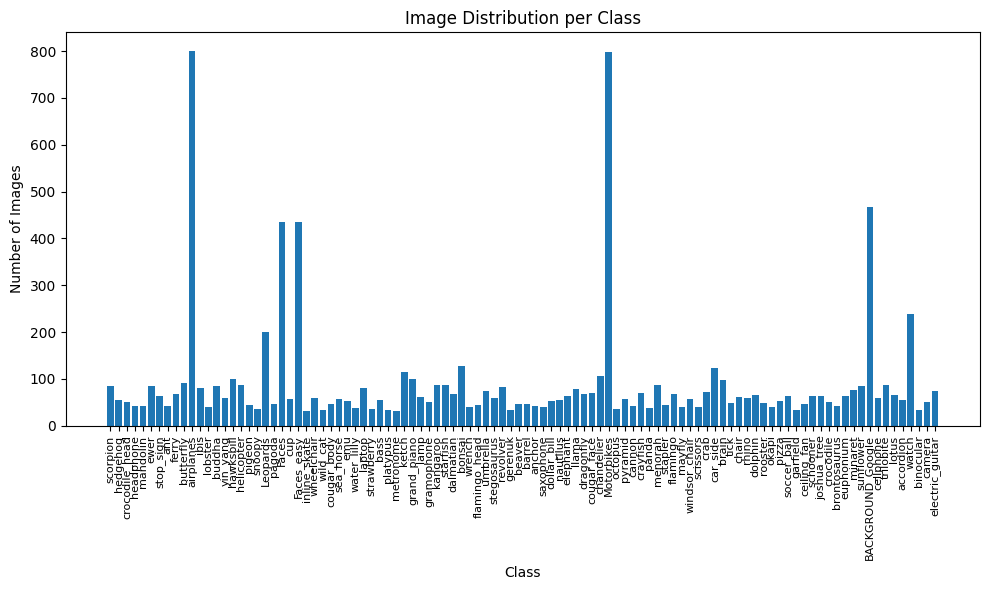

In [6]:
def count_images_per_class(data_dir):
    class_counts = {}
    classes = os.listdir(data_dir)
    for cls in classes:
        class_counts[cls] = len(os.listdir(os.path.join(data_dir, cls)))
    return class_counts

# Function to plot the distribution of images per class


def plot_image_distribution(class_counts):
    plt.figure(figsize=(10, 6))
    
    # Define the positions of the bars
    positions = np.arange(len(class_counts)) * 2.5  # Adjust the spacing as needed
    
    plt.bar(positions, class_counts.values(), align='center', width=2)  # Increase width for more spacing
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Image Distribution per Class')
    plt.xticks(positions, class_counts.keys(), rotation=90)  # Use positions as x-tick positions and set the labels
    plt.tick_params(axis='x', labelsize=8)  # Set the size of the x-axis labels
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()
    
class_counts = count_images_per_class('/kaggle/input/caltech-101/caltech-101')
plot_image_distribution(class_counts)


                

In [7]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the directory containing the organized dataset
dataset_dir = '/kaggle/input/caltech-101/caltech-101'

# Initialize empty lists to store images and labels
X_batches = []
y_batches = []

# Initialize class mapping
class_mapping = {}

# Loop through each class folder and assign numerical labels
label_counter = 0
for class_name in sorted(os.listdir(dataset_dir)):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Shuffle the images
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        random.shuffle(images)
        images = images[:100]  # Limit to 100 images per class
        
        # Map class name to numerical label
        class_mapping[class_name] = label_counter
        label_counter += 1

        # Load images and labels
        for image_path in images:
            # Load image and convert it to numpy array
            img = load_img(image_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            # Append image and label to batches
            X_batches.append(img_array)
            y_batches.append(class_mapping[class_name])

# Convert lists to numpy arrays
X_batches = np.array(X_batches)
y_batches = np.array(y_batches)

y_batches = np.squeeze(y_batches)

print("X_batches shape:", X_batches.shape)
print("y_batches shape:", y_batches.shape)
print("Class Mapping:", class_mapping)

X_batches shape: (6398, 150, 150, 3)
y_batches shape: (6398,)
Class Mapping: {'BACKGROUND_Google': 0, 'Faces': 1, 'Faces_easy': 2, 'Leopards': 3, 'Motorbikes': 4, 'accordion': 5, 'airplanes': 6, 'anchor': 7, 'ant': 8, 'barrel': 9, 'bass': 10, 'beaver': 11, 'binocular': 12, 'bonsai': 13, 'brain': 14, 'brontosaurus': 15, 'buddha': 16, 'butterfly': 17, 'camera': 18, 'cannon': 19, 'car_side': 20, 'ceiling_fan': 21, 'cellphone': 22, 'chair': 23, 'chandelier': 24, 'cougar_body': 25, 'cougar_face': 26, 'crab': 27, 'crayfish': 28, 'crocodile': 29, 'crocodile_head': 30, 'cup': 31, 'dalmatian': 32, 'dollar_bill': 33, 'dolphin': 34, 'dragonfly': 35, 'electric_guitar': 36, 'elephant': 37, 'emu': 38, 'euphonium': 39, 'ewer': 40, 'ferry': 41, 'flamingo': 42, 'flamingo_head': 43, 'garfield': 44, 'gerenuk': 45, 'gramophone': 46, 'grand_piano': 47, 'hawksbill': 48, 'headphone': 49, 'hedgehog': 50, 'helicopter': 51, 'ibis': 52, 'inline_skate': 53, 'joshua_tree': 54, 'kangaroo': 55, 'ketch': 56, 'lamp': 

In [8]:
# train_datagen = ImageDataGenerator(rescale=1./255)
# augmented_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(
#     '/kaggle/input/caltech-101/caltech-101',
#     target_size=(150, 150),
#     batch_size=100,
#     class_mode='categorical',
#     shuffle=True)
# len(train_generator)

# X, y = next(train_generator)

    


def rgb_to_grayscale(images):
    # Grayscale = 0.299 * R + 0.587 * G + 0.114 * B
    grayscale_images = 0.299 * images[:, 0, :, :] + 0.587 * images[:, 1, :, :] + 0.114 * images[:, 2, :, :]
    # Add a new dimension to represent the grayscale channel
    grayscale_images = grayscale_images.unsqueeze(1)
    return grayscale_images


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_batches, y_batches, test_size=0.2, random_state=42)

x_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2)
x_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)

# grayscale_train_tensor = rgb_to_grayscale(x_train_tensor)
# grayscale_test_tensor = rgb_to_grayscale(x_test_tensor)

# indices_of_ones_train = [np.argmax(arr) for arr in y_train]
# indices_of_ones_test = [np.argmax(arr) for arr in y_test]


# test_dataset = TensorDataset(grayscale_test_tensor, torch.tensor(y_test))
# train_dataset = TensorDataset(grayscale_train_tensor, torch.tensor(y_train))
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test))
train_dataset = TensorDataset(x_train_tensor, torch.tensor(y_train))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [11]:
def same_padding(kernel_size, stride=1):
    # For odd dimensions, we can pad evenly on both sides
    # For even dimensions, we will pad one more on the right/bottom side
    pad_val = (kernel_size - stride) // 2
    return (pad_val, pad_val + (kernel_size % 2 - 1))


def create_sparse_representations(batch, sparsity=0.5):
    # Function to create sparse representations and masks for a batch of images
    masks = torch.bernoulli(torch.ones_like(batch) * (1 - sparsity))
    sparse_batch = batch * masks
    return sparse_batch, masks

In [6]:
class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bias = torch.rand_like(torch.Tensor(out_channels)).to('cuda')

    def forward(self, input, mask):
        # Create a new mask
        new_mask = F.conv2d(mask, torch.ones_like(self.conv.weight), None, self.conv.stride, self.conv.padding)
        valid_pixel_amount = new_mask.clone().detach()
        # Apply convolution to the input
        output = self.conv(input * mask) * (self.conv.kernel_size[0] * self.conv.kernel_size[1])
        output = output.div(torch.add(valid_pixel_amount, 1e-5))
        output = output + self.bias.view(1,-1,1,1)

        new_mask = torch.ceil(new_mask.clamp_(0, 1))

        return output, new_mask

class SparseInvariantCNN(nn.Module):

    def __init__(self):
      super().__init__()
      self.fc = nn.Linear(150 * 150, 102)
      self.softmax = nn.Softmax(dim=1)
      self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=11, padding=same_padding(11)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=11, stride=1, padding=same_padding(11)),
        nn.Conv2d(16, 16, kernel_size=7, padding=same_padding(7)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=7, stride=1, padding=same_padding(7)),
        nn.Conv2d(16, 16, kernel_size=5, padding=same_padding(5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5, stride=1, padding=same_padding(5)),
        nn.Conv2d(16, 16, kernel_size=3, padding=same_padding(3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
        nn.Conv2d(16, 16, kernel_size=3, padding=same_padding(3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
        nn.Conv2d(16, 102, kernel_size=1, padding=same_padding(1)),
        nn.ReLU())
    

    def forward(self, x, mask):
        for layer in self.features:
            if isinstance(layer, SparseConv2d):
                x, mask = layer(x, mask)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = self.softmax(x)
        return x

In [25]:
class SparseConv(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size):
        super().__init__()

        padding = kernel_size//2

        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False)

        self.bias = nn.Parameter(
            torch.zeros(out_channels), 
            requires_grad=True)

        self.sparsity = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False)

        kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)

        self.sparsity.weight = nn.Parameter(
            data=kernel, 
            requires_grad=False)

        self.relu = nn.ReLU(inplace=True)


        self.max_pool = nn.MaxPool2d(
            kernel_size, 
            stride=1, 
            padding=padding)

        

    def forward(self, x, mask):
        x = x*mask
        x = self.conv(x)
        normalizer = 1/(self.sparsity(mask)+1e-8)
        x = x * normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        x = self.relu(x)
        
        mask = self.max_pool(mask)

        return x, mask



class SparseConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.SparseLayer1 = SparseConv(1, 16, 11)
        self.SparseLayer2 = SparseConv(16, 16, 7)
        self.SparseLayer3 = SparseConv(16, 16, 5)
        self.SparseLayer4 = SparseConv(16, 16, 3)
        self.SparseLayer5 = SparseConv(16, 16, 3)
        self.SparseLayer6 = SparseConv(16, 102, 1)

    def forward(self, x, mask):
        
        x, mask = self.SparseLayer1(x, mask)
        x, mask = self.SparseLayer2(x, mask)
        x, mask = self.SparseLayer3(x, mask)
        x, mask = self.SparseLayer4(x, mask)
        x, mask = self.SparseLayer5(x, mask)
        x, mask = self.SparseLayer6(x, mask)

        return x

In [9]:

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SparseInvariantCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 55

def evaluate_accuracy(data_loader, sparcity, net):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            sparse_images, masks = create_sparse_representations(images, sparsity=sparcity)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = net(sparse_images, masks)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Training loop
for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    sparcity = 0.7
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Create sparse representations and masks
        sparse_images, masks = create_sparse_representations(images, sparsity=sparcity)
        sparse_images, masks = sparse_images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, sparcity, net) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, sparcity, net) * 100
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')

Epoch 1/55
Loss: 8.4613, Training Accuracy: 1.15%, Test Accuracy: 1.17%
Epoch 2/55
Loss: 5.5313, Training Accuracy: 1.09%, Test Accuracy: 1.09%
Epoch 3/55
Loss: 5.1941, Training Accuracy: 1.27%, Test Accuracy: 1.41%
Epoch 4/55
Loss: 5.1143, Training Accuracy: 0.92%, Test Accuracy: 1.95%
Epoch 5/55
Loss: 5.0856, Training Accuracy: 1.11%, Test Accuracy: 1.41%
Epoch 6/55
Loss: 5.0557, Training Accuracy: 1.50%, Test Accuracy: 1.56%
Epoch 7/55
Loss: 5.0232, Training Accuracy: 1.41%, Test Accuracy: 1.41%
Epoch 8/55
Loss: 5.0189, Training Accuracy: 1.47%, Test Accuracy: 1.88%
Epoch 9/55
Loss: 5.0110, Training Accuracy: 1.95%, Test Accuracy: 2.58%
Epoch 10/55
Loss: 5.0019, Training Accuracy: 2.36%, Test Accuracy: 2.58%
Epoch 11/55
Loss: 4.9945, Training Accuracy: 1.47%, Test Accuracy: 1.88%
Epoch 12/55
Loss: 4.9995, Training Accuracy: 2.05%, Test Accuracy: 2.66%
Epoch 13/55
Loss: 4.9779, Training Accuracy: 1.64%, Test Accuracy: 2.27%
Epoch 14/55
Loss: 4.9720, Training Accuracy: 1.90%, Test Acc

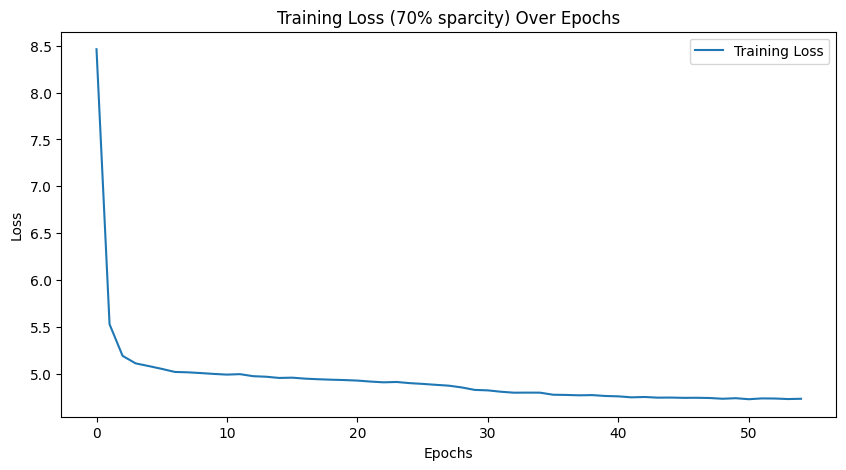

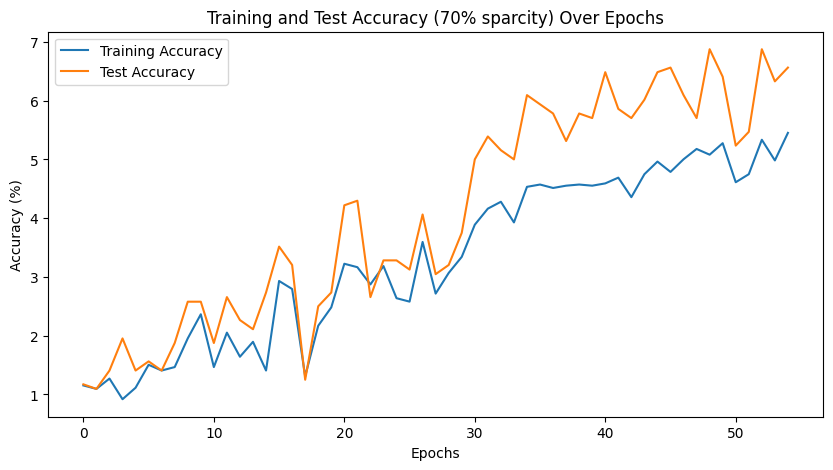

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
#TODO: Implement the function calculate_mae for table 3
# Debug the function calculate_mae
def calculate_mae(model, data_loader, device):
    model.eval()
    total_mae = 0.0
    total_count = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            mae = torch.abs(outputs - labels).mean()  # MAE calculation
            total_mae += mae.item() * images.size(0)
            total_count += images.size(0)

    average_mae = total_mae / total_count
    return average_mae

sparsity_levels = [0.8]
results = {}

for sparsity in sparsity_levels:
    model = SparseInvariantCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            sparse_images, masks = create_sparse_representations(images, sparsity)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = model(sparse_images, masks)
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1} completed for sparsity {sparsity*100}%')

    mae_performance = calculate_mae(model, test_loader, device)
    print(f'MAE at {sparsity*100}% sparsity: {mae_performance}')
    results[sparsity] = mae_performance

for sparsity, mae in results.items():
    print(f'Sparsity: {sparsity*100}%, MAE: {mae}')

In [ ]:

# Set model to evaluation mode
net.eval()
sparcity = 0.7
# Iterate over test dataset
for inputs, labels in test_loader:
    # Move inputs to the appropriate device
    inputs = inputs.to(device)
    sparse_images, masks = create_sparse_representations(inputs, sparsity=sparcity)
    sparse_images, masks = sparse_images.to(device), masks.to(device)
    # Forward pass
    outputs = net(sparse_images, masks)
    print(outputs.shape)
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Convert tensors to numpy arrays for easy comparison
    predicted_labels = predicted.cpu().numpy()
    true_labels = labels.numpy()
    
    # Print predicted and true labels
    for i in range(len(predicted_labels)):
        print(f"Predicted: {predicted_labels[i]}, True: {true_labels[i]}")

In [9]:
class NormalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, padding=(11-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=11, stride=1, padding=(11-1)//2),
            nn.Conv2d(16, 16, kernel_size=7, padding=(7-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=1, padding=(7-1)//2),
            nn.Conv2d(16, 16, kernel_size=5, padding=(5-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=(5-1)//2),
            nn.Conv2d(16, 16, kernel_size=3, padding=(3-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=(3-1)//2),
            nn.Conv2d(16, 16, kernel_size=3, padding=(3-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=(3-1)//2),
            nn.Conv2d(16, 102, kernel_size=1, padding=(1-1)//2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = NormalCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 55

def evaluate_accuracy(data_loader, net, device):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            # Assuming you still want to evaluate on sparse data
            sparse_images, _ = create_sparse_representations(images, sparsity=0.7)  # Example sparsity
            sparse_images = sparse_images.to(device)

            outputs = net(sparse_images)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total



for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    sparcity = 0.7  # Example sparsity
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Create sparse representations (assuming you're comparing performance on sparse data)
        sparse_images, _ = create_sparse_representations(images, sparsity=sparcity)
        sparse_images = sparse_images.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images)  # Adjusted to not use masks
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and log average loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, net, device) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, net, device) * 100
    test_accs.append(test_acc)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')

Epoch 1/55
Loss: 8.2756, Training Accuracy: 0.64%, Test Accuracy: 0.39%
Epoch 2/55
Loss: 5.7526, Training Accuracy: 1.00%, Test Accuracy: 1.17%
Epoch 3/55
Loss: 5.1549, Training Accuracy: 0.98%, Test Accuracy: 1.25%
Epoch 4/55
Loss: 5.0614, Training Accuracy: 1.17%, Test Accuracy: 1.25%
Epoch 5/55
Loss: 5.0122, Training Accuracy: 1.29%, Test Accuracy: 1.56%
Epoch 6/55
Loss: 4.9758, Training Accuracy: 1.15%, Test Accuracy: 1.64%
Epoch 7/55
Loss: 4.9567, Training Accuracy: 1.50%, Test Accuracy: 1.33%
Epoch 8/55
Loss: 4.9436, Training Accuracy: 1.15%, Test Accuracy: 1.95%
Epoch 9/55
Loss: 4.9248, Training Accuracy: 1.64%, Test Accuracy: 2.27%
Epoch 10/55
Loss: 4.9145, Training Accuracy: 1.29%, Test Accuracy: 1.95%
Epoch 11/55
Loss: 4.9066, Training Accuracy: 1.52%, Test Accuracy: 2.03%
Epoch 12/55
Loss: 4.9012, Training Accuracy: 1.43%, Test Accuracy: 2.11%
Epoch 13/55
Loss: 4.8957, Training Accuracy: 1.33%, Test Accuracy: 1.25%
Epoch 14/55
Loss: 4.9000, Training Accuracy: 1.70%, Test Acc

In [ ]:
net.eval()
sparcity = 0.7
# Iterate over test dataset
for inputs, labels in test_loader:
    # Move inputs to the appropriate device
    inputs = inputs.to(device)
    sparse_images, masks = create_sparse_representations(inputs, sparsity=sparcity)
    sparse_images, masks = sparse_images.to(device), masks.to(device)
    # Forward pass
    outputs = net(sparse_images)
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Convert tensors to numpy arrays for easy comparison
    predicted_labels = predicted.cpu().numpy()
    true_labels = labels.numpy()
    
    # Print predicted and true labels
    for i in range(len(predicted_labels)):
        print(f"Predicted: {predicted_labels[i]}, True: {true_labels[i]}")

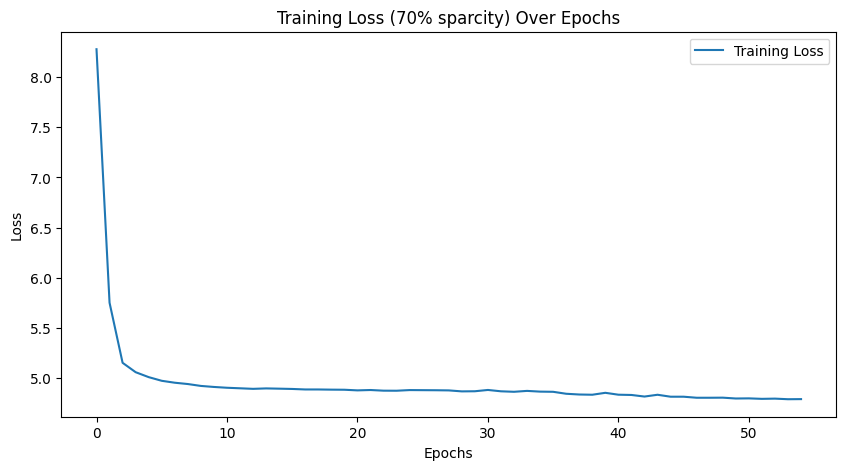

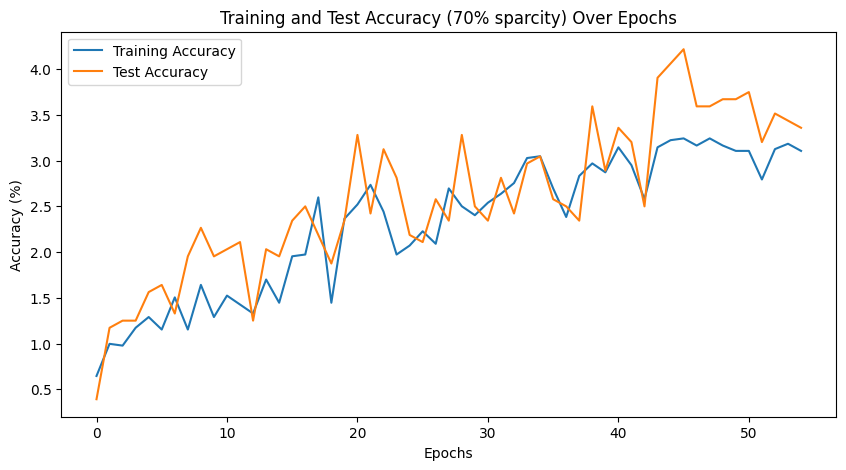

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()